# Second Competition: Modulation format classification

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

#import library
#from dnn_util import *

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [189]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [190]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

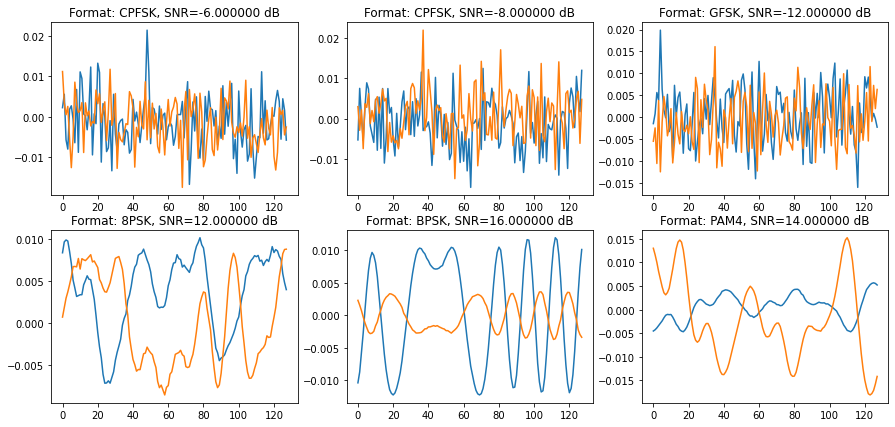

In [191]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

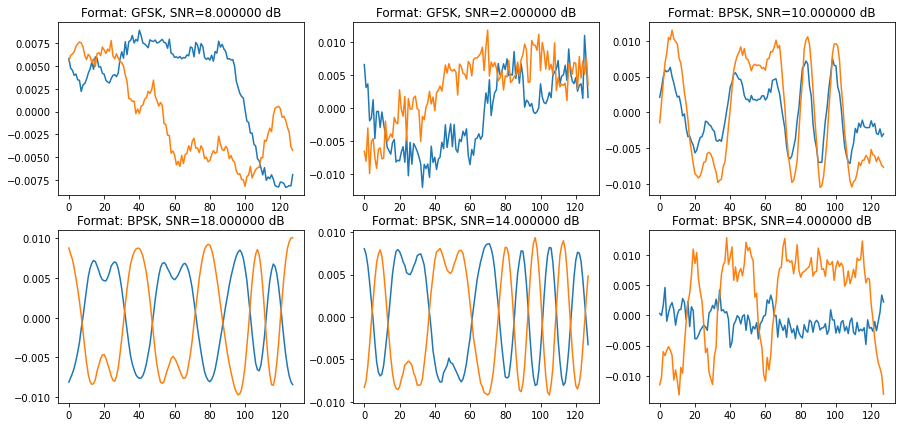

In [192]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

Below are the helper's function to compute neural network. Most of the code are obtained from Coursera Course : Neural Network and Deep Learning by Andrew Ng

In [200]:

def sigmoid(Z):
    #sigmoid activation function 
    A = 1/(1+np.exp(-Z))
    cache = Z
    #return A and cache
    return A,cache

def relu(Z):
    #ReLu activation function
    A = np.maximum(0,Z)

    assert (A.shape == Z.shape)

    cache = Z
    return A, cache

def relu_backward(dA, cache):
    #backward propagation for relu activation function
    Z = cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    #backward propagation for sigmoid activation function
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ= dA * s * (1-s)
    assert (dZ.shape == Z.shape)

    return dZ

def initialize_parameters(n_x,n_h,n_y):
    #initialize parameters
    np.random.seed(1) #seed 1
    W1 = np.random.randn(n_h,n_x)*np.sqrt(2/n_x) #initialize with he initialization
    b1 = np.zeros((n_h,1))                       #zero initialization
    W2 = np.random.randn(n_y,n_h)*np.sqrt(2/n_h) #
    b2 = np.zeros((n_y,1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,}

    return parameters

def initialize_parameters_deep(layer_dims):
    #initialize parameters for deep learning neural network
    #layer_dim is an array contain the dimension of each layer in network
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

def linear_forward(A,W,b):
    #the linear part of the layer propagation network
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    #implement the forward propagation for the linear activation
    if activation =="sigmoid":
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = relu(Z)

    assert (A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (lin_cache, act_cache)

    return A, cache

def L_model_forward(X, parameters):
    #implement forward propagation for the linear relu and linear relu 

    caches = []
    A = X
    L = len(parameters)//2
    #loop over the neural network layers
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W' + str(l)], parameters['b' + str(l)],
                                            activation = "relu")
        caches.append(cache)
    
    #implement linear sigmoid activation for the last layer
    AL, cache = linear_activation_forward(A,parameters['W' + str(L)], parameters['b' + str(L)], 
                                        activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL,caches

def compute_cost(AL,Y):
    #calculate cost function
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())

    return cost

def linear_backward(dZ, cache):
    #implement a linear portion of backward prop for single layer
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    #implement the backward prop 
    lin_cache, act_cache = cache

    if activation == "relu":        
        dZ = relu_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    #implement a linear backward propagation for linear relu and linear sigmoid
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



def update_parameters(parameters, grads, learning_rate):
    #update the parameters using gradient descent
    L = len(parameters) // 2
    #update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters


def deep_network_model(X,Y,layer_dims,learning_rate=0.01,num_iter=2500,print_cost=False):
    #implementation of multiple layer neural network

    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layer_dims)

    #loop over to calculate gradient descent
    for i in range(0, num_iter):
        #forward propagation
        AL, caches = L_model_forward(X,parameters)

        #calculate the cost
        cost = compute_cost(AL,Y)

        #Backward Propagation
        grads = L_model_backward(AL,Y,caches)

        #update parameters
        parameters = update_parameters(parameters,grads,learning_rate)

        #print cost every 100th examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    #plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

# helper function to compute the classification error rate
def CER(predictions, labels):
    return (np.sum(predictions != labels) / np.size(predictions))

#function to predict output from input and neural network parameters
def make_prediction(X,params):
    m = X.shape[1]
    p = np.zeros((1,m))
    A2,cache = L_model_forward(X,params)
    
    for i in range(0,A2.shape[1]):
        if A2[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return p




Cost after iteration 0: 0.693047
Cost after iteration 100: 0.691542
Cost after iteration 200: 0.690802
Cost after iteration 300: 0.689981
Cost after iteration 400: 0.688922
Cost after iteration 500: 0.687396
Cost after iteration 600: 0.684981
Cost after iteration 700: 0.680750
Cost after iteration 800: 0.672441
Cost after iteration 900: 0.654269
Cost after iteration 1000: 0.612949
Cost after iteration 1100: 0.535341
Cost after iteration 1200: 0.520773
Cost after iteration 1300: 0.483245
Cost after iteration 1400: 0.435345
Cost after iteration 1500: 0.390777
Cost after iteration 1600: 0.118443
Cost after iteration 1700: 0.043844
Cost after iteration 1800: 0.019471
Cost after iteration 1900: 0.011156
Cost after iteration 2000: 0.007404
Cost after iteration 2100: 0.005374
Cost after iteration 2200: 0.004138
Cost after iteration 2300: 0.003321
Cost after iteration 2400: 0.002749
Cost after iteration 2500: 0.002329
Cost after iteration 2600: 0.002010
Cost after iteration 2700: 0.001761
Cost

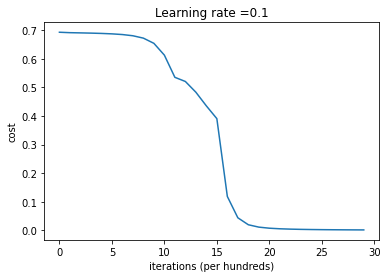

Erorr rate for training set ,SNR -20 dB = 0.0
Error rate for validation set ,SNR -20 dB = 0.5412844036697247
Cost after iteration 0: 0.693129
Cost after iteration 100: 0.692261
Cost after iteration 200: 0.691675
Cost after iteration 300: 0.690998
Cost after iteration 400: 0.690100
Cost after iteration 500: 0.688760
Cost after iteration 600: 0.686586
Cost after iteration 700: 0.682746
Cost after iteration 800: 0.674795
Cost after iteration 900: 0.657374
Cost after iteration 1000: 0.617930
Cost after iteration 1100: 0.547068
Cost after iteration 1200: 0.526185
Cost after iteration 1300: 0.491451
Cost after iteration 1400: 0.445639
Cost after iteration 1500: 0.395617
Cost after iteration 1600: 1.185153
Cost after iteration 1700: 0.051964
Cost after iteration 1800: 0.021326
Cost after iteration 1900: 0.011770
Cost after iteration 2000: 0.007658
Cost after iteration 2100: 0.005495
Cost after iteration 2200: 0.004201
Cost after iteration 2300: 0.003355
Cost after iteration 2400: 0.002767
Cos

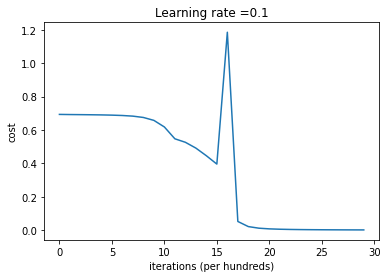

Erorr rate for training set ,SNR -18 dB = 0.0
Error rate for validation set ,SNR -18 dB = 0.5400593471810089
Cost after iteration 0: 0.693488
Cost after iteration 100: 0.692828
Cost after iteration 200: 0.692469
Cost after iteration 300: 0.692105
Cost after iteration 400: 0.691689
Cost after iteration 500: 0.691206
Cost after iteration 600: 0.690599
Cost after iteration 700: 0.689791
Cost after iteration 800: 0.688661
Cost after iteration 900: 0.686999
Cost after iteration 1000: 0.684318
Cost after iteration 1100: 0.679596
Cost after iteration 1200: 0.670509
Cost after iteration 1300: 0.650923
Cost after iteration 1400: 0.607281
Cost after iteration 1500: 0.527386
Cost after iteration 1600: 0.513412
Cost after iteration 1700: 0.468421
Cost after iteration 1800: 0.413032
Cost after iteration 1900: 0.361489
Cost after iteration 2000: 0.440483
Cost after iteration 2100: 0.038715
Cost after iteration 2200: 0.017720
Cost after iteration 2300: 0.010414
Cost after iteration 2400: 0.007024
Cos

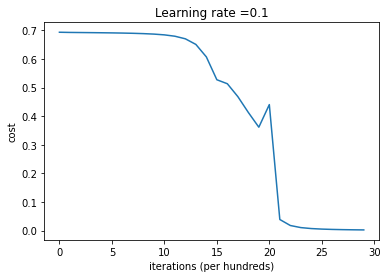

Erorr rate for training set ,SNR -16 dB = 0.0
Error rate for validation set ,SNR -16 dB = 0.5482954545454546
Cost after iteration 0: 0.693295
Cost after iteration 100: 0.692663
Cost after iteration 200: 0.692154
Cost after iteration 300: 0.691560
Cost after iteration 400: 0.690824
Cost after iteration 500: 0.689881
Cost after iteration 600: 0.688519
Cost after iteration 700: 0.686375
Cost after iteration 800: 0.682718
Cost after iteration 900: 0.675677
Cost after iteration 1000: 0.660577
Cost after iteration 1100: 0.625001
Cost after iteration 1200: 0.554380
Cost after iteration 1300: 0.524304
Cost after iteration 1400: 0.494786
Cost after iteration 1500: 0.451480
Cost after iteration 1600: 0.382358
Cost after iteration 1700: 0.209712
Cost after iteration 1800: 0.066979
Cost after iteration 1900: 0.025599
Cost after iteration 2000: 0.013292
Cost after iteration 2100: 0.008374
Cost after iteration 2200: 0.005890
Cost after iteration 2300: 0.004443
Cost after iteration 2400: 0.003516
Cos

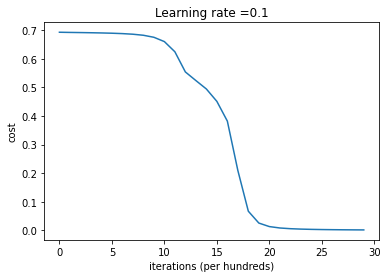

Erorr rate for training set ,SNR -14 dB = 0.0
Error rate for validation set ,SNR -14 dB = 0.5111111111111111
Cost after iteration 0: 0.693015
Cost after iteration 100: 0.692468
Cost after iteration 200: 0.692013
Cost after iteration 300: 0.691494
Cost after iteration 400: 0.690862
Cost after iteration 500: 0.690089
Cost after iteration 600: 0.689064
Cost after iteration 700: 0.687626
Cost after iteration 800: 0.685449
Cost after iteration 900: 0.681979
Cost after iteration 1000: 0.675739
Cost after iteration 1100: 0.663273
Cost after iteration 1200: 0.636348
Cost after iteration 1300: 0.580647
Cost after iteration 1400: 0.496339
Cost after iteration 1500: 0.507964
Cost after iteration 1600: 0.474454
Cost after iteration 1700: 0.354052
Cost after iteration 1800: 0.267326
Cost after iteration 1900: 0.082629
Cost after iteration 2000: 0.035432
Cost after iteration 2100: 0.016151
Cost after iteration 2200: 0.009387
Cost after iteration 2300: 0.006452
Cost after iteration 2400: 0.004804
Cos

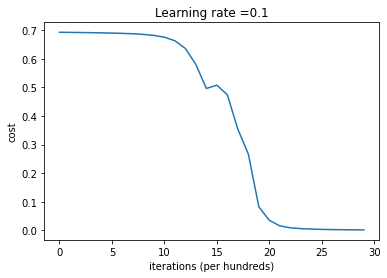

Erorr rate for training set ,SNR -12 dB = 0.0
Error rate for validation set ,SNR -12 dB = 0.4876543209876543
Cost after iteration 0: 0.693306
Cost after iteration 100: 0.692054
Cost after iteration 200: 0.691289
Cost after iteration 300: 0.690443
Cost after iteration 400: 0.689349
Cost after iteration 500: 0.687739
Cost after iteration 600: 0.685162
Cost after iteration 700: 0.680776
Cost after iteration 800: 0.672709
Cost after iteration 900: 0.656429
Cost after iteration 1000: 0.621866
Cost after iteration 1100: 0.556705
Cost after iteration 1200: 0.520875
Cost after iteration 1300: 0.491831
Cost after iteration 1400: 0.441342
Cost after iteration 1500: 0.638451
Cost after iteration 1600: 0.118051
Cost after iteration 1700: 0.040920
Cost after iteration 1800: 0.018227
Cost after iteration 1900: 0.010536
Cost after iteration 2000: 0.007040
Cost after iteration 2100: 0.005136
Cost after iteration 2200: 0.003971
Cost after iteration 2300: 0.003197
Cost after iteration 2400: 0.002653
Cos

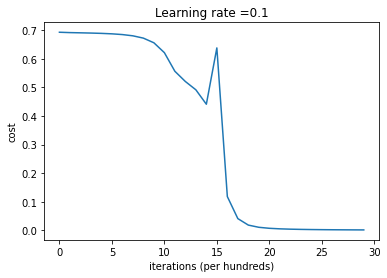

Erorr rate for training set ,SNR -10 dB = 0.0
Error rate for validation set ,SNR -10 dB = 0.4785276073619632
Cost after iteration 0: 0.693069
Cost after iteration 100: 0.692216
Cost after iteration 200: 0.691584
Cost after iteration 300: 0.690759
Cost after iteration 400: 0.689598
Cost after iteration 500: 0.687758
Cost after iteration 600: 0.684519
Cost after iteration 700: 0.678634
Cost after iteration 800: 0.666692
Cost after iteration 900: 0.639292
Cost after iteration 1000: 0.579147
Cost after iteration 1100: 0.527795
Cost after iteration 1200: 0.496069
Cost after iteration 1300: 0.437133
Cost after iteration 1400: 0.364219
Cost after iteration 1500: 0.096590
Cost after iteration 1600: 0.042855
Cost after iteration 1700: 0.018553
Cost after iteration 1800: 0.010608
Cost after iteration 1900: 0.007046
Cost after iteration 2000: 0.005123
Cost after iteration 2100: 0.003951
Cost after iteration 2200: 0.003175
Cost after iteration 2300: 0.002631
Cost after iteration 2400: 0.002231
Cos

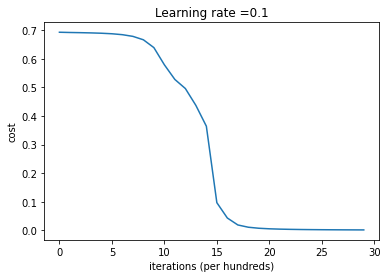

Erorr rate for training set ,SNR -8 dB = 0.0
Error rate for validation set ,SNR -8 dB = 0.396969696969697
Cost after iteration 0: 0.693305
Cost after iteration 100: 0.692337
Cost after iteration 200: 0.691915
Cost after iteration 300: 0.691443
Cost after iteration 400: 0.690826
Cost after iteration 500: 0.690054
Cost after iteration 600: 0.688979
Cost after iteration 700: 0.687357
Cost after iteration 800: 0.684906
Cost after iteration 900: 0.680631
Cost after iteration 1000: 0.671775
Cost after iteration 1100: 0.651322
Cost after iteration 1200: 0.599567
Cost after iteration 1300: 0.471343
Cost after iteration 1400: 0.446513
Cost after iteration 1500: 0.333775
Cost after iteration 1600: 0.086025
Cost after iteration 1700: 0.031225
Cost after iteration 1800: 0.015502
Cost after iteration 1900: 0.009424
Cost after iteration 2000: 0.006463
Cost after iteration 2100: 0.004789
Cost after iteration 2200: 0.003740
Cost after iteration 2300: 0.003031
Cost after iteration 2400: 0.002527
Cost a

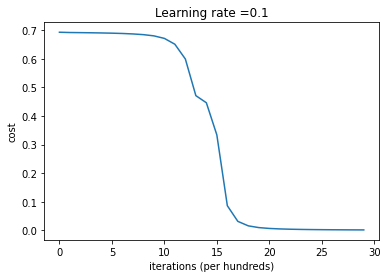

Erorr rate for training set ,SNR -6 dB = 0.0
Error rate for validation set ,SNR -6 dB = 0.2981366459627329
Cost after iteration 0: 0.693231
Cost after iteration 100: 0.691998
Cost after iteration 200: 0.691156
Cost after iteration 300: 0.689962
Cost after iteration 400: 0.687827
Cost after iteration 500: 0.684033
Cost after iteration 600: 0.676688
Cost after iteration 700: 0.659640
Cost after iteration 800: 0.611721
Cost after iteration 900: 0.465244
Cost after iteration 1000: 0.318073
Cost after iteration 1100: 0.096220
Cost after iteration 1200: 0.032731
Cost after iteration 1300: 0.015919
Cost after iteration 1400: 0.009513
Cost after iteration 1500: 0.006450
Cost after iteration 1600: 0.004739
Cost after iteration 1700: 0.003676
Cost after iteration 1800: 0.002964
Cost after iteration 1900: 0.002461
Cost after iteration 2000: 0.002089
Cost after iteration 2100: 0.001806
Cost after iteration 2200: 0.001583
Cost after iteration 2300: 0.001405
Cost after iteration 2400: 0.001259
Cost 

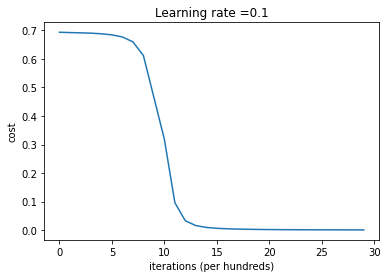

Erorr rate for training set ,SNR -4 dB = 0.0
Error rate for validation set ,SNR -4 dB = 0.30538922155688625
Cost after iteration 0: 0.693323
Cost after iteration 100: 0.692120
Cost after iteration 200: 0.690746
Cost after iteration 300: 0.688197
Cost after iteration 400: 0.683110
Cost after iteration 500: 0.670683
Cost after iteration 600: 0.632212
Cost after iteration 700: 0.479866
Cost after iteration 800: 0.264145
Cost after iteration 900: 0.064858
Cost after iteration 1000: 0.025943
Cost after iteration 1100: 0.013527
Cost after iteration 1200: 0.008416
Cost after iteration 1300: 0.005844
Cost after iteration 1400: 0.004360
Cost after iteration 1500: 0.003417
Cost after iteration 1600: 0.002777
Cost after iteration 1700: 0.002318
Cost after iteration 1800: 0.001976
Cost after iteration 1900: 0.001713
Cost after iteration 2000: 0.001505
Cost after iteration 2100: 0.001338
Cost after iteration 2200: 0.001201
Cost after iteration 2300: 0.001087
Cost after iteration 2400: 0.000991
Cost

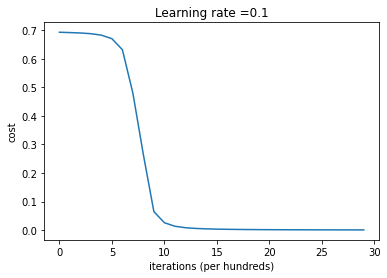

Erorr rate for training set ,SNR -2 dB = 0.0
Error rate for validation set ,SNR -2 dB = 0.2732919254658385
Cost after iteration 0: 0.693383
Cost after iteration 100: 0.691114
Cost after iteration 200: 0.687406
Cost after iteration 300: 0.677883
Cost after iteration 400: 0.645858
Cost after iteration 500: 0.489048
Cost after iteration 600: 0.180259
Cost after iteration 700: 0.064017
Cost after iteration 800: 0.026908
Cost after iteration 900: 0.014084
Cost after iteration 1000: 0.008722
Cost after iteration 1100: 0.006026
Cost after iteration 1200: 0.004476
Cost after iteration 1300: 0.003498
Cost after iteration 1400: 0.002836
Cost after iteration 1500: 0.002363
Cost after iteration 1600: 0.002012
Cost after iteration 1700: 0.001743
Cost after iteration 1800: 0.001530
Cost after iteration 1900: 0.001359
Cost after iteration 2000: 0.001219
Cost after iteration 2100: 0.001102
Cost after iteration 2200: 0.001004
Cost after iteration 2300: 0.000920
Cost after iteration 2400: 0.000848
Cost 

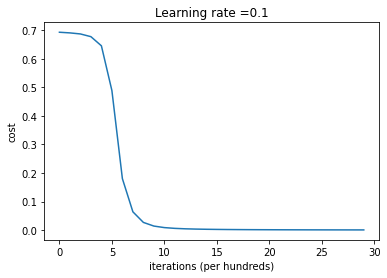

Erorr rate for training set ,SNR 0 dB = 0.0
Error rate for validation set ,SNR 0 dB = 0.12758620689655173
Cost after iteration 0: 0.693451
Cost after iteration 100: 0.690400
Cost after iteration 200: 0.685741
Cost after iteration 300: 0.671318
Cost after iteration 400: 0.612032
Cost after iteration 500: 0.332857
Cost after iteration 600: 0.098460
Cost after iteration 700: 0.037073
Cost after iteration 800: 0.017781
Cost after iteration 900: 0.010384
Cost after iteration 1000: 0.006901
Cost after iteration 1100: 0.004990
Cost after iteration 1200: 0.003824
Cost after iteration 1300: 0.003056
Cost after iteration 1400: 0.002518
Cost after iteration 1500: 0.002124
Cost after iteration 1600: 0.001826
Cost after iteration 1700: 0.001594
Cost after iteration 1800: 0.001409
Cost after iteration 1900: 0.001258
Cost after iteration 2000: 0.001134
Cost after iteration 2100: 0.001030
Cost after iteration 2200: 0.000941
Cost after iteration 2300: 0.000865
Cost after iteration 2400: 0.000800
Cost a

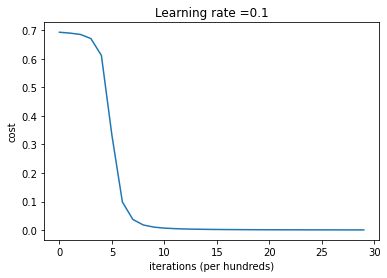

Erorr rate for training set ,SNR 2 dB = 0.0
Error rate for validation set ,SNR 2 dB = 0.03278688524590164
Cost after iteration 0: 0.693569
Cost after iteration 100: 0.690256
Cost after iteration 200: 0.685632
Cost after iteration 300: 0.670121
Cost after iteration 400: 0.601668
Cost after iteration 500: 0.293879
Cost after iteration 600: 0.086988
Cost after iteration 700: 0.035862
Cost after iteration 800: 0.018778
Cost after iteration 900: 0.011504
Cost after iteration 1000: 0.007846
Cost after iteration 1100: 0.005749
Cost after iteration 1200: 0.004436
Cost after iteration 1300: 0.003556
Cost after iteration 1400: 0.002935
Cost after iteration 1500: 0.002479
Cost after iteration 1600: 0.002131
Cost after iteration 1700: 0.001859
Cost after iteration 1800: 0.001642
Cost after iteration 1900: 0.001466
Cost after iteration 2000: 0.001320
Cost after iteration 2100: 0.001197
Cost after iteration 2200: 0.001094
Cost after iteration 2300: 0.001004
Cost after iteration 2400: 0.000927
Cost a

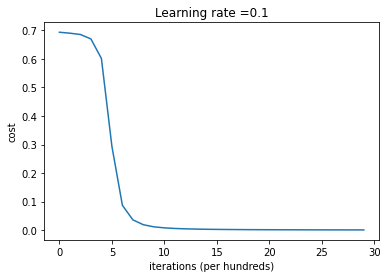

Erorr rate for training set ,SNR 4 dB = 0.0
Error rate for validation set ,SNR 4 dB = 0.04838709677419355
Cost after iteration 0: 0.693519
Cost after iteration 100: 0.689323
Cost after iteration 200: 0.680407
Cost after iteration 300: 0.649197
Cost after iteration 400: 0.476038
Cost after iteration 500: 0.143397
Cost after iteration 600: 0.049561
Cost after iteration 700: 0.023144
Cost after iteration 800: 0.013233
Cost after iteration 900: 0.008641
Cost after iteration 1000: 0.006168
Cost after iteration 1100: 0.004678
Cost after iteration 1200: 0.003703
Cost after iteration 1300: 0.003027
Cost after iteration 1400: 0.002537
Cost after iteration 1500: 0.002167
Cost after iteration 1600: 0.001882
Cost after iteration 1700: 0.001656
Cost after iteration 1800: 0.001474
Cost after iteration 1900: 0.001325
Cost after iteration 2000: 0.001200
Cost after iteration 2100: 0.001094
Cost after iteration 2200: 0.001003
Cost after iteration 2300: 0.000926
Cost after iteration 2400: 0.000858
Cost a

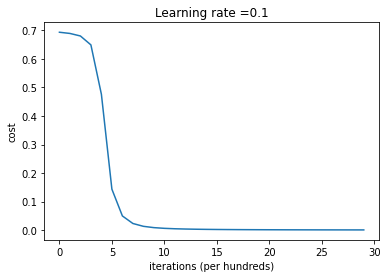

Erorr rate for training set ,SNR 6 dB = 0.0
Error rate for validation set ,SNR 6 dB = 0.0029940119760479044
Cost after iteration 0: 0.693637
Cost after iteration 100: 0.689019
Cost after iteration 200: 0.678651
Cost after iteration 300: 0.638184
Cost after iteration 400: 0.409254
Cost after iteration 500: 0.111403
Cost after iteration 600: 0.045091
Cost after iteration 700: 0.024804
Cost after iteration 800: 0.016757
Cost after iteration 900: 0.012796
Cost after iteration 1000: 0.009883
Cost after iteration 1100: 0.006902
Cost after iteration 1200: 0.005114
Cost after iteration 1300: 0.004006
Cost after iteration 1400: 0.003261
Cost after iteration 1500: 0.002727
Cost after iteration 1600: 0.002326
Cost after iteration 1700: 0.002014
Cost after iteration 1800: 0.001769
Cost after iteration 1900: 0.001571
Cost after iteration 2000: 0.001410
Cost after iteration 2100: 0.001276
Cost after iteration 2200: 0.001162
Cost after iteration 2300: 0.001066
Cost after iteration 2400: 0.000982
Cost

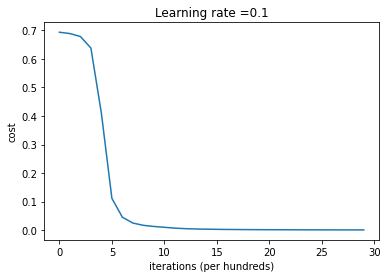

Erorr rate for training set ,SNR 8 dB = 0.0
Error rate for validation set ,SNR 8 dB = 0.01607717041800643
Cost after iteration 0: 0.693344
Cost after iteration 100: 0.689268
Cost after iteration 200: 0.680402
Cost after iteration 300: 0.649940
Cost after iteration 400: 0.487717
Cost after iteration 500: 0.148454
Cost after iteration 600: 0.049680
Cost after iteration 700: 0.023279
Cost after iteration 800: 0.013401
Cost after iteration 900: 0.008808
Cost after iteration 1000: 0.006318
Cost after iteration 1100: 0.004794
Cost after iteration 1200: 0.003794
Cost after iteration 1300: 0.003100
Cost after iteration 1400: 0.002597
Cost after iteration 1500: 0.002219
Cost after iteration 1600: 0.001927
Cost after iteration 1700: 0.001696
Cost after iteration 1800: 0.001509
Cost after iteration 1900: 0.001355
Cost after iteration 2000: 0.001227
Cost after iteration 2100: 0.001119
Cost after iteration 2200: 0.001027
Cost after iteration 2300: 0.000947
Cost after iteration 2400: 0.000877
Cost a

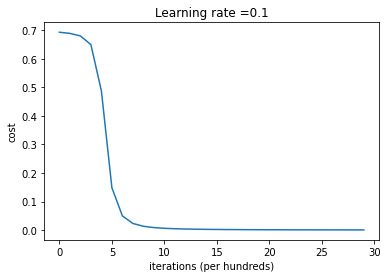

Erorr rate for training set ,SNR 10 dB = 0.0
Error rate for validation set ,SNR 10 dB = 0.009230769230769232
Cost after iteration 0: 0.693549
Cost after iteration 100: 0.688163
Cost after iteration 200: 0.676995
Cost after iteration 300: 0.636418
Cost after iteration 400: 0.424116
Cost after iteration 500: 0.110182
Cost after iteration 600: 0.040218
Cost after iteration 700: 0.020350
Cost after iteration 800: 0.012295
Cost after iteration 900: 0.008312
Cost after iteration 1000: 0.006057
Cost after iteration 1100: 0.004650
Cost after iteration 1200: 0.003710
Cost after iteration 1300: 0.003053
Cost after iteration 1400: 0.002572
Cost after iteration 1500: 0.002207
Cost after iteration 1600: 0.001924
Cost after iteration 1700: 0.001699
Cost after iteration 1800: 0.001515
Cost after iteration 1900: 0.001364
Cost after iteration 2000: 0.001237
Cost after iteration 2100: 0.001129
Cost after iteration 2200: 0.001036
Cost after iteration 2300: 0.000957
Cost after iteration 2400: 0.000887
Cos

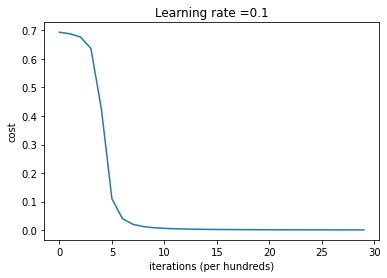

Erorr rate for training set ,SNR 12 dB = 0.0
Error rate for validation set ,SNR 12 dB = 0.015384615384615385
Cost after iteration 0: 0.693703
Cost after iteration 100: 0.688789
Cost after iteration 200: 0.677642
Cost after iteration 300: 0.636762
Cost after iteration 400: 0.415160
Cost after iteration 500: 0.104443
Cost after iteration 600: 0.036032
Cost after iteration 700: 0.017669
Cost after iteration 800: 0.010535
Cost after iteration 900: 0.007104
Cost after iteration 1000: 0.005183
Cost after iteration 1100: 0.003997
Cost after iteration 1200: 0.003206
Cost after iteration 1300: 0.002647
Cost after iteration 1400: 0.002237
Cost after iteration 1500: 0.001926
Cost after iteration 1600: 0.001683
Cost after iteration 1700: 0.001489
Cost after iteration 1800: 0.001331
Cost after iteration 1900: 0.001200
Cost after iteration 2000: 0.001090
Cost after iteration 2100: 0.000997
Cost after iteration 2200: 0.000917
Cost after iteration 2300: 0.000848
Cost after iteration 2400: 0.000787
Cos

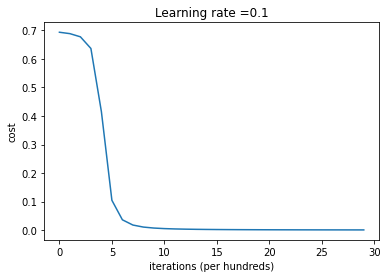

Erorr rate for training set ,SNR 14 dB = 0.0
Error rate for validation set ,SNR 14 dB = 0.0
Cost after iteration 0: 0.693408
Cost after iteration 100: 0.690235
Cost after iteration 200: 0.685032
Cost after iteration 300: 0.669021
Cost after iteration 400: 0.595797
Cost after iteration 500: 0.263500
Cost after iteration 600: 0.077052
Cost after iteration 700: 0.032469
Cost after iteration 800: 0.017390
Cost after iteration 900: 0.010853
Cost after iteration 1000: 0.007494
Cost after iteration 1100: 0.005556
Cost after iteration 1200: 0.004328
Cost after iteration 1300: 0.003495
Cost after iteration 1400: 0.002900
Cost after iteration 1500: 0.002460
Cost after iteration 1600: 0.002123
Cost after iteration 1700: 0.001858
Cost after iteration 1800: 0.001646
Cost after iteration 1900: 0.001473
Cost after iteration 2000: 0.001329
Cost after iteration 2100: 0.001207
Cost after iteration 2200: 0.001104
Cost after iteration 2300: 0.001016
Cost after iteration 2400: 0.000939
Cost after iteration

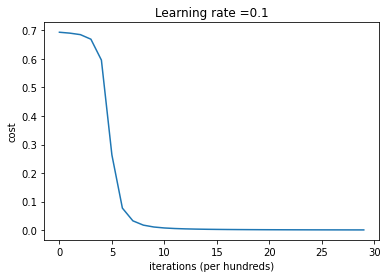

Erorr rate for training set ,SNR 16 dB = 0.0
Error rate for validation set ,SNR 16 dB = 0.003257328990228013
Cost after iteration 0: 0.693420
Cost after iteration 100: 0.688697
Cost after iteration 200: 0.679207
Cost after iteration 300: 0.643100
Cost after iteration 400: 0.441409
Cost after iteration 500: 0.128830
Cost after iteration 600: 0.045428
Cost after iteration 700: 0.021991
Cost after iteration 800: 0.012938
Cost after iteration 900: 0.008619
Cost after iteration 1000: 0.006224
Cost after iteration 1100: 0.004764
Cost after iteration 1200: 0.003799
Cost after iteration 1300: 0.003123
Cost after iteration 1400: 0.002630
Cost after iteration 1500: 0.002256
Cost after iteration 1600: 0.001965
Cost after iteration 1700: 0.001732
Cost after iteration 1800: 0.001544
Cost after iteration 1900: 0.001388
Cost after iteration 2000: 0.001259
Cost after iteration 2100: 0.001149
Cost after iteration 2200: 0.001055
Cost after iteration 2300: 0.000973
Cost after iteration 2400: 0.000902
Cos

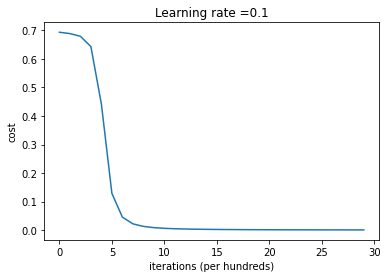

Erorr rate for training set ,SNR 18 dB = 0.0
Error rate for validation set ,SNR 18 dB = 0.0182370820668693


In [205]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
#training and validation input data
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

#label training and validation data
Y     = np.equal(y_train_task1,4)              #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)                        #convert data type to float
Y     = Y.reshape(-1,1).transpose()            #reshape the array
Y_val = np.equal(y_valid_task1,4)              #set 0 as BPSK and 1 as GFSK
Y_val = Y_val.astype(float)                    #convert data type to float
Y_val = Y_val.reshape(-1,1).transpose()        #reshape the array 

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables
alpha = 0.1                                    #learning rate  
num_iteration = 3000                           #number of iteration
layer_dims = [X.shape[0],128,32,16,1]          #4 layers model

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1)        #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range))        #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))  #Error rate training data

#loop over all SNR value
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    
    
    #feed the data to Neural Network model
    params = deep_network_model(X_train_SNR,Y_train_SNR,layer_dims,alpha,num_iteration,True)
    #make a prediction    
    Y_pred_train = make_prediction(X_train_SNR,params) #prediction on training data
    Y_pred = make_prediction(X_valid_SNR,params)       #prediction on validation data
    
    #calculate the error for every SNR value
    Error_rates_train[idx] = CER(Y_pred_train,Y_train_SNR)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)    
    
    print("Erorr rate for training set ,SNR "+str(value)+" dB = "+str(Error_rates_train[idx]))
    print("Error rate for validation set ,SNR "+str(value)+" dB = "+str(Error_rates[idx])) 
   

Plot the classification error for each SNR value

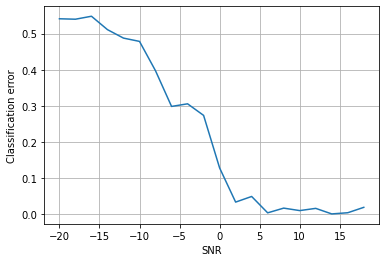

In [206]:
plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

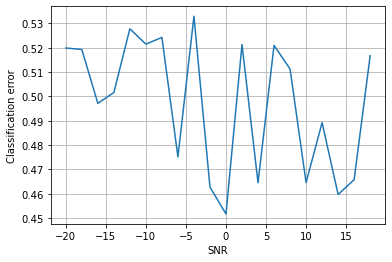

In [207]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)